<a href="https://colab.research.google.com/github/GorokhovSemyon/TextClassification/blob/main/VisualLLMEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [ ]:
!pip install evaluate numpy torch tensorboard datasets tqdm transformers wandb clearml

## Подключение необходимых библиотек

In [ ]:
import evaluate
import numpy as np
import torch
from datasets import DatasetDict
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import get_scheduler
from transformers import Trainer, TrainerCallback
from transformers import TrainingArguments
from torch.utils.tensorboard import SummaryWriter

# Гиперпараметры

In [ ]:
BATCH_SIZE = 64
LR = 1e-4
LR_TYPE = 'cosine'  # 'linear', 'constant'
N_EPOCHS = 5
WARMUP_STEPS = 20

## Инициализация ClearML

In [ ]:
# Инициализация задачи ClearML
task = Task.init(project_name='TextClassification', task_name='VisualEval', tags=['Model:prajjwal1/bert-tiny', 'type:notebook'])

In [ ]:
# Логирование гиперпараметров
task.connect({'BATCH_SIZE': BATCH_SIZE, 'LR': LR, 'LR_TYPE': LR_TYPE, 'N_EPOCHS': N_EPOCHS, 'WARMUP_STEPS': WARMUP_STEPS})

{'BATCH_SIZE': 64,
 'LR': 0.0001,
 'LR_TYPE': 'cosine',
 'N_EPOCHS': 5,
 'WARMUP_STEPS': 20}

In [ ]:
# Создание логгера
logger = task.get_logger()

# Загрузка датасета yelp_review_full

In [ ]:
ds = load_dataset("yelp_review_full")


ds = DatasetDict({
    'train': ds['train'].shuffle(seed=1).select(range(5000)),
    'test': ds['test'].shuffle(seed=1).select(range(500)),
})

task.upload_artifact(name="ds.train", artifact_object=ds['train'])
task.upload_artifact(name="ds.test", artifact_object=ds['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning:


Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).



Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

True

# Токенизация датасета

In [ ]:
model_id = 'prajjwal1/bert-tiny'

tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
    )

tokenized_ds = ds.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Пайплайн обучения HuggingFace

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=5)

training_args = TrainingArguments(
    output_dir='output',
    learning_rate=LR,
    lr_scheduler_type=LR_TYPE,
    warmup_steps=WARMUP_STEPS,
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',  # где будем хранить логи
    logging_steps=10,  # логировать каждые 10 шагов
)

metric_accuracy = evaluate.load("accuracy")
metric_recall = evaluate.load("recall")
metric_precision = evaluate.load("precision")
metric_f1 = evaluate.load("f1")

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

2024-07-27 17:34:07,997 - clearml.model - INFO - Selected model id: 09257a9f938048be84686e6c41b13b90


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



## Вывод метрик ClearML

In [ ]:
from clearml import Task, Logger

EXPERIMENT_NUM = 2

def log_metrics_to_clearml(logger, experiment_num, accuracy, recall, precision, f1):
    logger.report_scalar("Accuracy", "Accuracy", accuracy, iteration=experiment_num)
    logger.report_scalar("Recall", "Recall", recall, iteration=experiment_num)
    logger.report_scalar("Precision", "Precision", precision, iteration=experiment_num)
    logger.report_scalar("F1", "F1", f1, iteration=experiment_num)



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    recall = metric_recall.compute(predictions=predictions, references=labels, average='macro')
    precision = metric_precision.compute(predictions=predictions, references=labels, average='macro')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')

    print(accuracy, recall, precision, f1)

    log_metrics_to_clearml(logger, EXPERIMENT_NUM, accuracy['accuracy'], recall['recall'], precision['precision'], f1['f1'])

    return {**accuracy, **recall, **precision, **f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    compute_metrics=compute_metrics
)

trainer.train()


2024-07-27 18:14:03,452 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers_7/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.578900,1.400970,0.470000,0.462848,0.470988,0.465550
2,0.894700,1.417235,0.484000,0.473083,0.463201,0.464919
3,0.744400,1.424464,0.478000,0.469432,0.478551,0.471807
4,0.702900,1.424954,0.468000,0.462117,0.466073,0.462690
5,0.664500,1.431764,0.470000,0.462671,0.471278,0.465417


{'accuracy': 0.47} {'recall': 0.4628478064191023} {'precision': 0.4709882182190729} {'f1': 0.46555024719252025}
{'accuracy': 0.484} {'recall': 0.4730826711411611} {'precision': 0.46320078596089287} {'f1': 0.4649186263563923}
{'accuracy': 0.478} {'recall': 0.4694321880200354} {'precision': 0.4785513644423018} {'f1': 0.47180667817085126}
{'accuracy': 0.468} {'recall': 0.4621173094672607} {'precision': 0.4660733629614834} {'f1': 0.4626900550429962}
{'accuracy': 0.47} {'recall': 0.4626712572811452} {'precision': 0.4712779156327544} {'f1': 0.4654171174546161}


TrainOutput(global_step=395, training_loss=0.7101397278942639, metrics={'train_runtime': 425.3653, 'train_samples_per_second': 58.773, 'train_steps_per_second': 0.929, 'total_flos': 7947974400000.0, 'train_loss': 0.7101397278942639, 'epoch': 5.0})

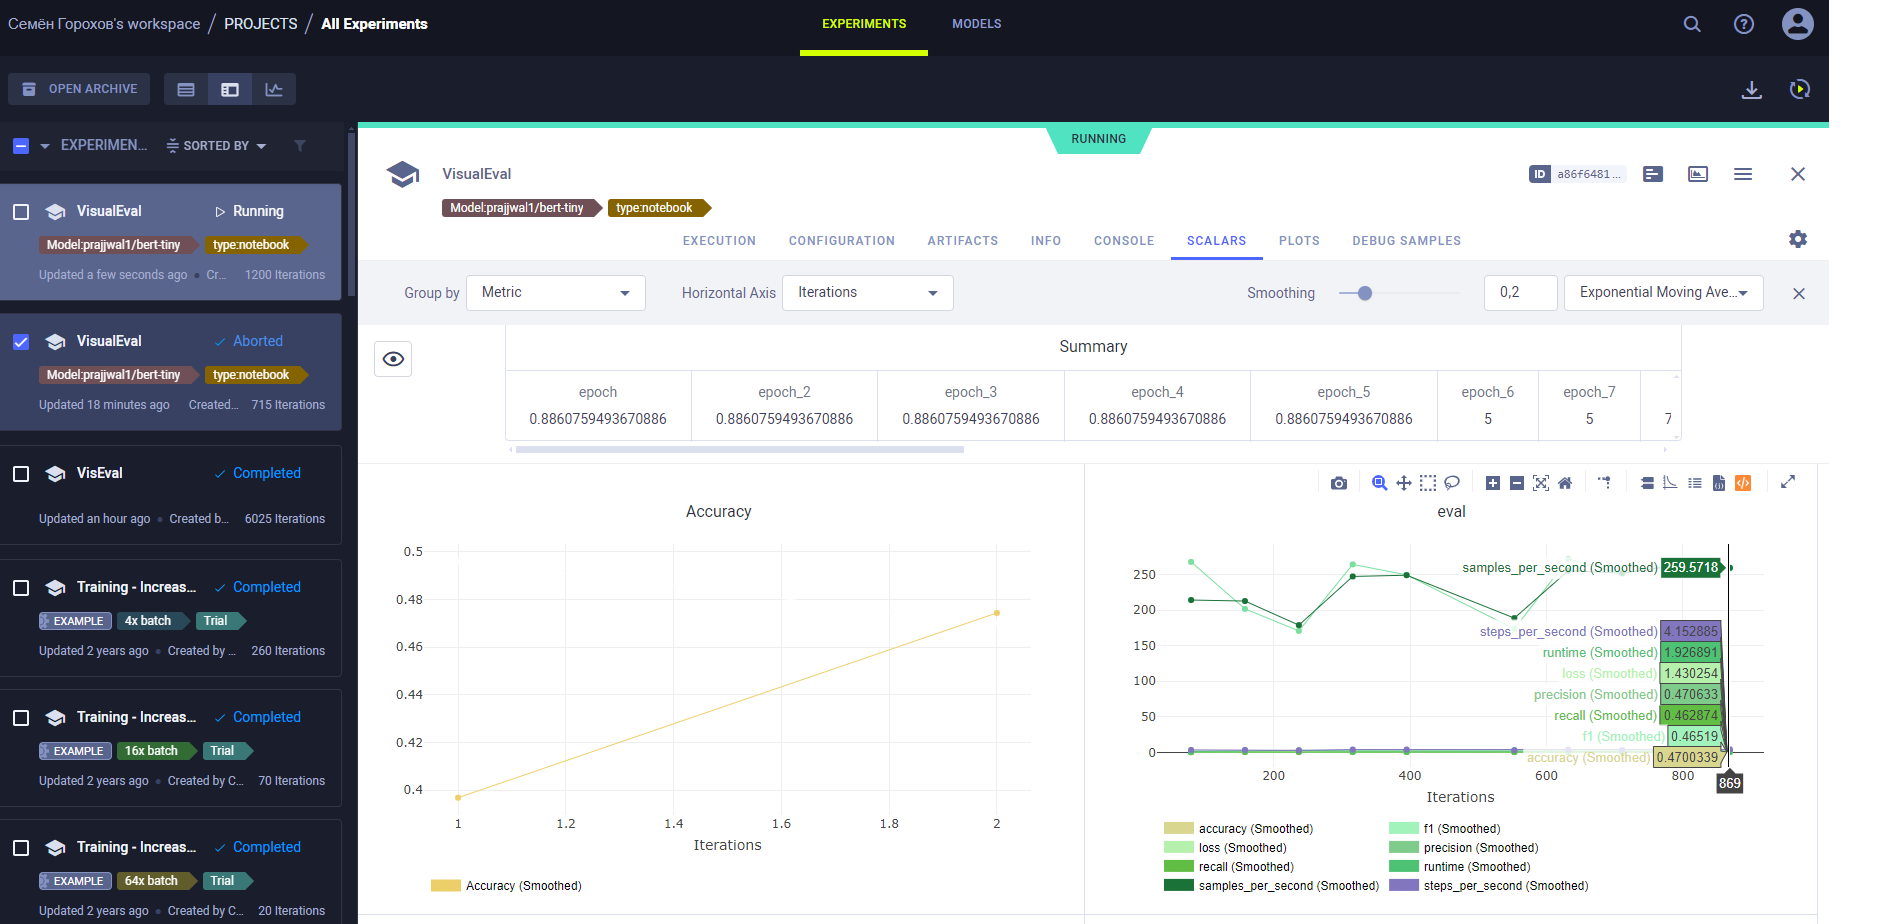

## Вывод метрик Wandb

In [22]:
import wandb

EXPERIMENT_NUM = 1

wandb.init(project='TextClassification', name='VisualEval')

def log_metrics_to_wandb(experiment_num, accuracy, recall, precision, f1):
    wandb.log({"Accuracy": accuracy, "Recall": recall, "Precision": precision, "F1": f1}, step=experiment_num)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    recall = metric_recall.compute(predictions=predictions, references=labels, average='macro')
    precision = metric_precision.compute(predictions=predictions, references=labels, average='macro')
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')

    print(accuracy, recall, precision, f1)

    log_metrics_to_wandb(EXPERIMENT_NUM, accuracy['accuracy'], recall['recall'], precision['precision'], f1['f1'])

    return {**accuracy, **recall, **precision, **f1}

# Инициализация wandb
wandb.init(project="my_project", name="experiment_2")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['test'],
    compute_metrics=compute_metrics
)

trainer.train()


eval/accuracy,▅▇▇██▂▅▃▁▂
eval/f1,▅▅▆██▂▂▃▁▂
eval/loss,▃▁▁▁▁▇▇███
eval/precision,▇▄▆▇█▃▁▄▂▃
eval/recall,▄▇▇██▁▄▃▁▁
eval/runtime,▁▅█▁▂█▁▂▁▂
eval/samples_per_second,█▃▁▇▆▁█▇█▇
eval/steps_per_second,█▃▁▇▆▁█▇█▇
train/epoch,▁▂▂▁▂▁▂▁▂▁▂▂▂▂▂▃▄▄▅▅▆▆▇▇██▁▂▂▃▄▄▄▅▆▆▇▇██
train/global_step,▁▂▂▁▂▁▂▁▂▁▂▂▂▂▂▃▄▄▅▅▆▆▇▇██▁▂▂▃▄▄▄▅▆▆▇▇██
train/grad_norm,▁▁▁▁▁▂▂▂▁▃▂▂▃▂▃▅▃▃▃▅▂▂▃▂▂▂▄▄▃▂▅▂█▂▂▄▃▅▇▃


2024-07-27 18:40:16,453 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers_8/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.396600,1.585933,0.472000,0.464066,0.480449,0.469964
2,0.666400,1.642869,0.464000,0.455641,0.468301,0.456402
3,0.528200,1.641359,0.478000,0.468302,0.475515,0.470406
4,0.537900,1.645965,0.478000,0.472693,0.480223,0.474729
5,0.544500,1.654310,0.486000,0.479932,0.490275,0.483535


{'accuracy': 0.472} {'recall': 0.4640656153329946} {'precision': 0.4804493902824287} {'f1': 0.4699639890695564}


wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 1 is less than current step: 7. Dropping entry: {'Accuracy': 0.472, 'Recall': 0.4640656153329946, 'Precision': 0.4804493902824287, 'F1': 0.4699639890695564, '_timestamp': 1722105689.365701}).


{'accuracy': 0.464} {'recall': 0.4556408227892522} {'precision': 0.46830112341383484} {'f1': 0.4564018074671566}


wandb: WARNING (User provided step: 1 is less than current step: 16. Dropping entry: {'Accuracy': 0.464, 'Recall': 0.4556408227892522, 'Precision': 0.46830112341383484, 'F1': 0.4564018074671566, '_timestamp': 1722105775.5755467}).


{'accuracy': 0.478} {'recall': 0.46830178934498007} {'precision': 0.4755150141353969} {'f1': 0.47040631763381296}


wandb: WARNING (User provided step: 1 is less than current step: 25. Dropping entry: {'Accuracy': 0.478, 'Recall': 0.46830178934498007, 'Precision': 0.4755150141353969, 'F1': 0.47040631763381296, '_timestamp': 1722105853.6652257}).


{'accuracy': 0.478} {'recall': 0.47269326203941703} {'precision': 0.4802229741586845} {'f1': 0.4747286354478888}


wandb: WARNING (User provided step: 1 is less than current step: 34. Dropping entry: {'Accuracy': 0.478, 'Recall': 0.47269326203941703, 'Precision': 0.4802229741586845, 'F1': 0.4747286354478888, '_timestamp': 1722105940.3693454}).


{'accuracy': 0.486} {'recall': 0.479931663203791} {'precision': 0.4902753540564223} {'f1': 0.4835348282917586}


wandb: WARNING (User provided step: 1 is less than current step: 43. Dropping entry: {'Accuracy': 0.486, 'Recall': 0.479931663203791, 'Precision': 0.4902753540564223, 'F1': 0.4835348282917586, '_timestamp': 1722106033.1703353}).


TrainOutput(global_step=395, training_loss=0.5237498555002333, metrics={'train_runtime': 425.7193, 'train_samples_per_second': 58.724, 'train_steps_per_second': 0.928, 'total_flos': 7947974400000.0, 'train_loss': 0.5237498555002333, 'epoch': 5.0})

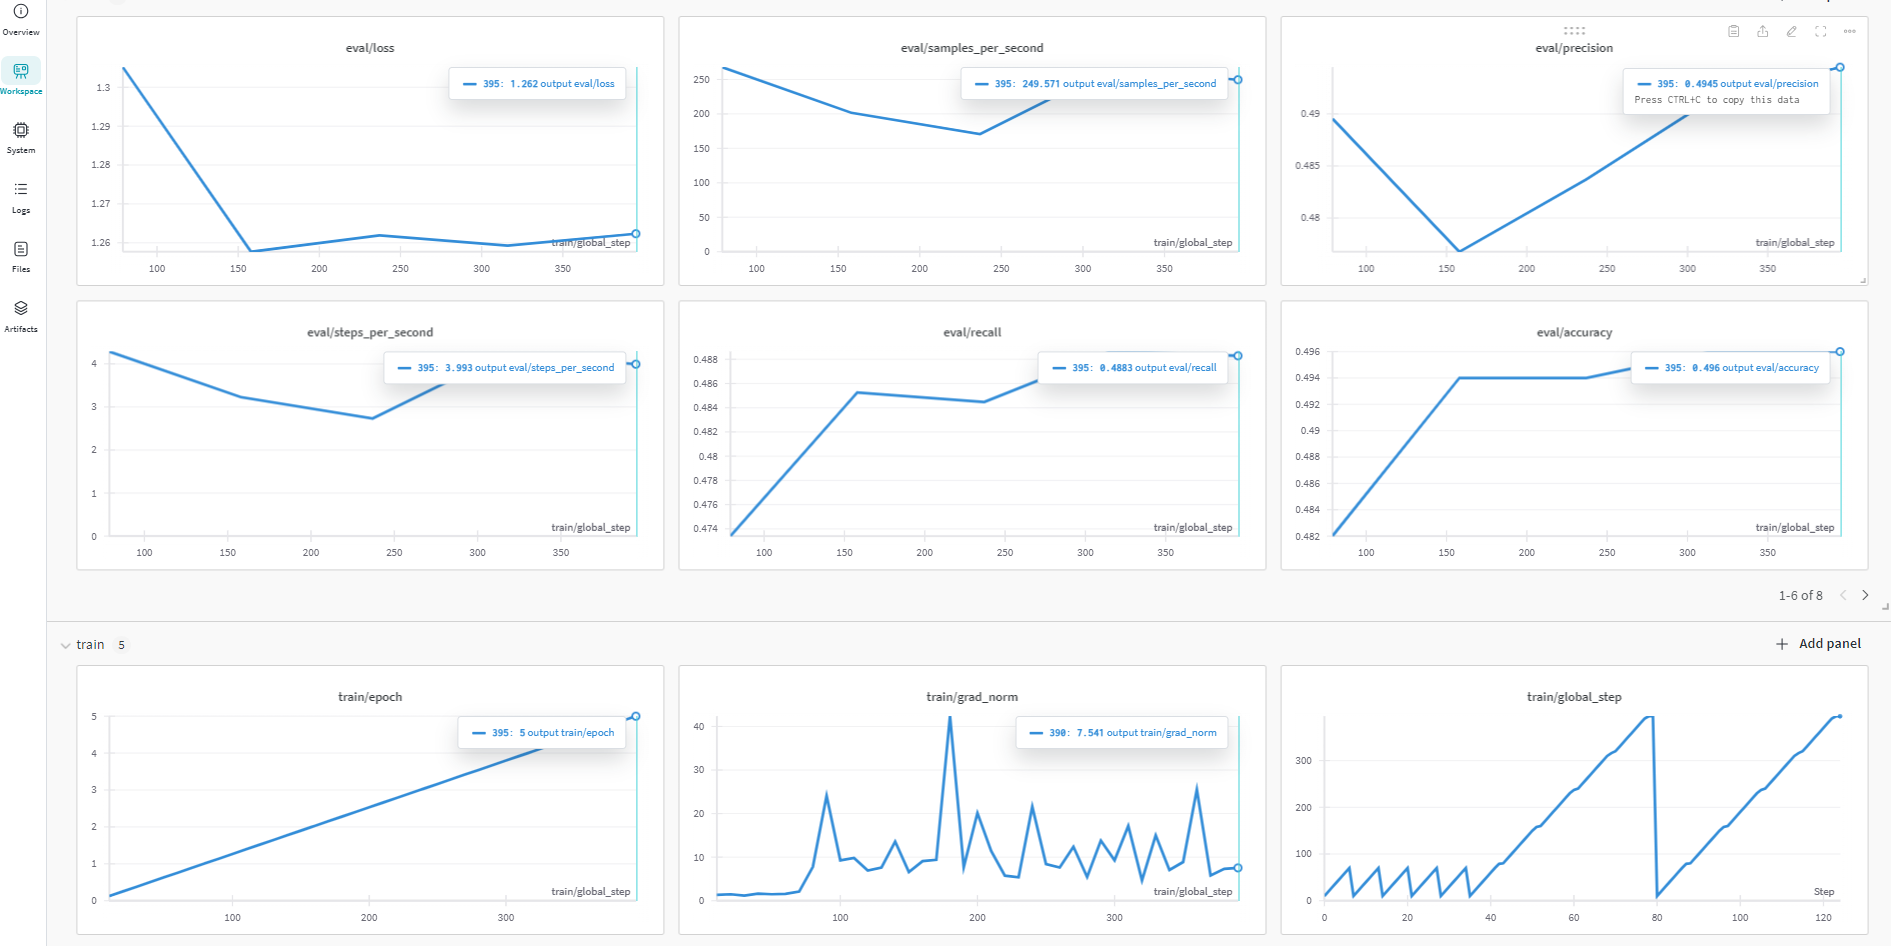

# Вывод

Получилось подключить к проекту средства визуализации результатов ClearML и Wandb, функционал оказался достаточно полезным и удобным, теперь можно более наглядно сравнивать результаты похожих экспериментов, используя данный инструмент.

Автоматически генерируемые Trainer'ом метрики достаточно информативны, но стоит указать, что создание кастомных также доступно и немаловажно.

В качестве кастомизации была введена возможность сравнения текущего эксперимента с предыдущим по стандартным метрикам. Чтобы это сделать просто нужно запускать новый эксперимент с уникальным идентификатором (EXPERIMENT_NUM).